# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [2]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [3]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# Option B: Upload your own CSV (uncomment to use in Colab)
from google.colab import files
up = files.upload()  # pick file
import io
df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
print("Shape:", df.shape)
df.head()


Saving titanic_sample.csv to titanic_sample.csv
Shape: (10, 4)


,PassengerId,Name,Age,Embarked
0,1,Allen,22.0,S
1,2,Braund,38.0,C
2,3,Cumings,NaN,C
3,4,Futrelle,35.0,NaN
4,5,Palsson,8.0,S


In [5]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [6]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [7]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [8]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

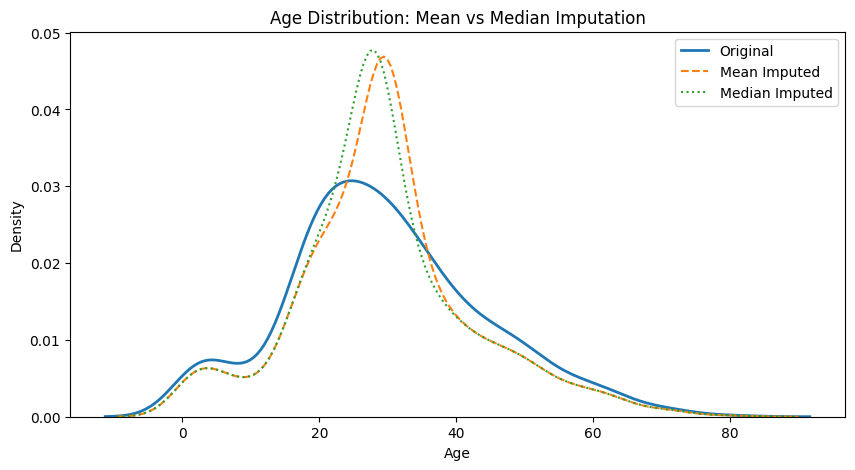

Original:
 Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64 

Unknown:
 Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64 

Mode:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64 



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

df_mean = df.copy()
df_median = df.copy()

df_mean['Age'] = df_mean['Age'].fillna(df['Age'].mean())
df_median['Age'] = df_median['Age'].fillna(df['Age'].median())

plt.figure(figsize=(10,5))
sns.kdeplot(df['Age'], label='Original', linewidth=2)
sns.kdeplot(df_mean['Age'], label='Mean Imputed', linestyle='--')
sns.kdeplot(df_median['Age'], label='Median Imputed', linestyle=':')
plt.legend()
plt.title("Age Distribution: Mean vs Median Imputation")
plt.show()


df_unknown = df.copy()
df_unknown['Embarked'] = df_unknown['Embarked'].fillna('Unknown')

df_mode = df.copy()
mode_value = df['Embarked'].mode()[0]
df_mode['Embarked'] = df_mode['Embarked'].fillna(mode_value)

print("Original:\n", df['Embarked'].value_counts(dropna=False), "\n")
print("Unknown:\n", df_unknown['Embarked'].value_counts(), "\n")
print("Mode:\n", df_mode['Embarked'].value_counts(), "\n")


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

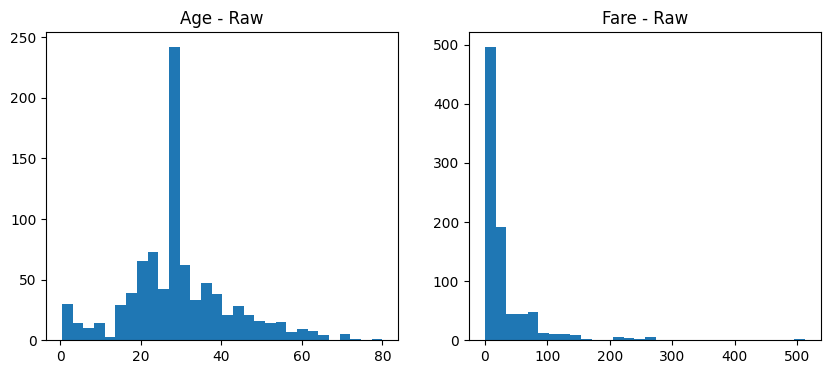

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

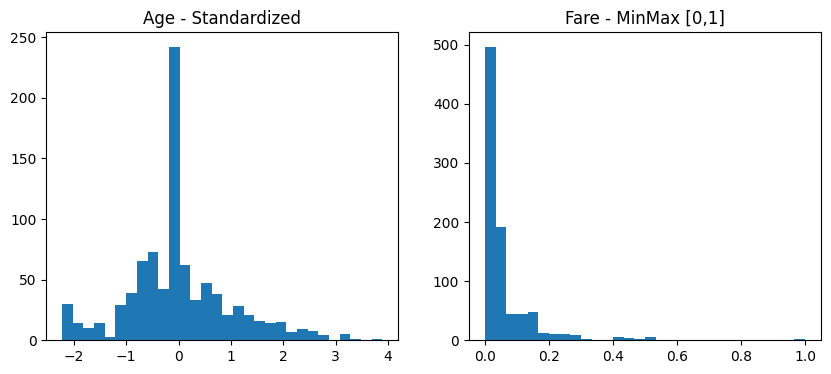

In [15]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

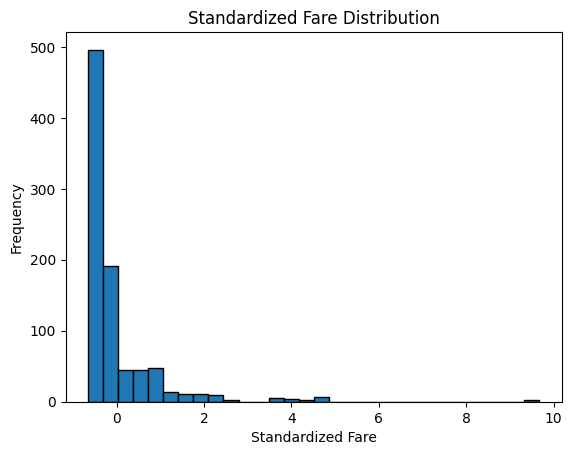

[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

scaler = StandardScaler()
df_imp['Fare_std'] = scaler.fit_transform(df_imp[['Fare']])

plt.hist(df_imp['Fare_std'], bins=30, edgecolor='black')
plt.title("Standardized Fare Distribution")
plt.xlabel("Standardized Fare")
plt.ylabel("Frequency")
plt.show()

normalizer = Normalizer()
normalized = normalizer.fit_transform(df_imp[['Age','Fare']].fillna(0))
print(normalized[:5])

## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [17]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [18]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

Because ordinal encoding implies an artificial order (e.g., `C=0, Q=1, S=2`), a linear model might wrongly treat categories as ranked or evenly spaced.
One-hot encoding  avoids this by giving each category its own independent binary feature, so the model won’t assume false numeric relationships.


In [20]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal = OrdinalEncoder()
onehot = OneHotEncoder(sparse_output=False)

ordinal_encoded = ordinal.fit_transform(df[['Embarked']].fillna('Unknown'))
onehot_encoded = onehot.fit_transform(df[['Embarked']].fillna('Unknown'))

print("Ordinal features:", ordinal_encoded.shape[1])
print("One-hot features:", onehot_encoded.shape[1])


Ordinal features: 1
One-hot features: 4


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

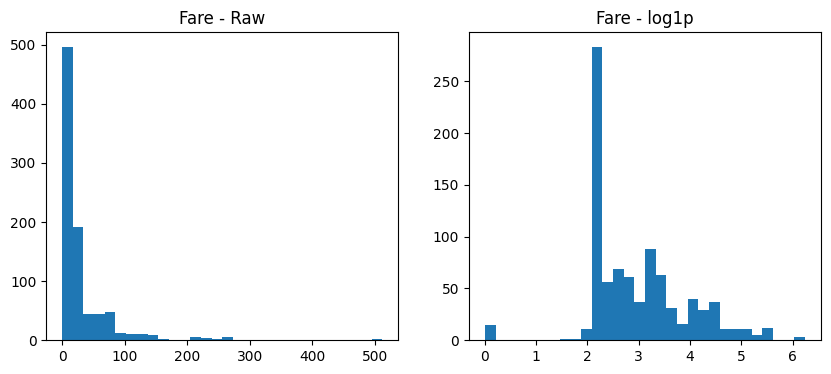

In [21]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

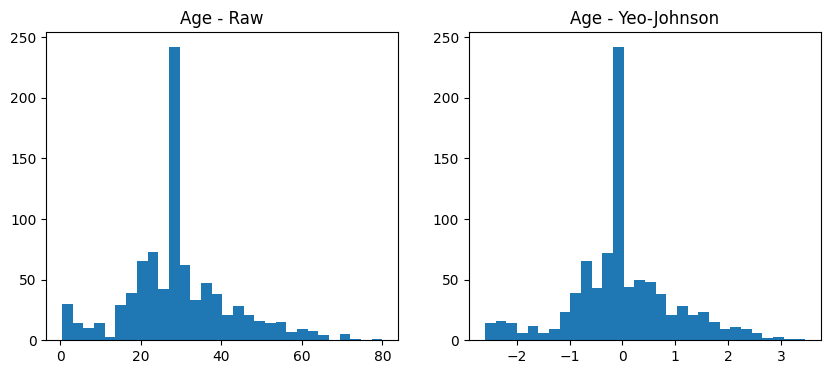

In [22]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [23]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

With degree = 2 and two inputs (Age, Fare), the expanded feature set is:
Age
Fare
Age²
Age × Fare
Fare²

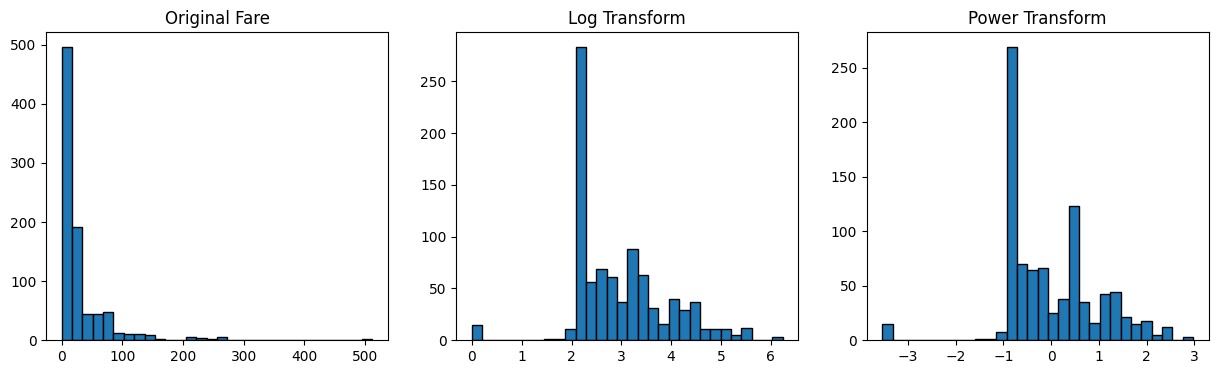

Feature names: ['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']
First 5 rows:
 [[  22.            7.25        484.          159.5          52.5625    ]
 [  38.           71.2833     1444.         2708.7654     5081.30885889]
 [  26.            7.925       676.          206.05         62.805625  ]
 [  35.           53.1        1225.         1858.5        2819.61      ]
 [  35.            8.05       1225.          281.75         64.8025    ]]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(df_imp['Fare'].dropna(), bins=30, edgecolor='black')
axes[0].set_title("Original Fare")

axes[1].hist(np.log1p(df_imp['Fare'].dropna()), bins=30, edgecolor='black')
axes[1].set_title("Log Transform")

pt = PowerTransformer(method='yeo-johnson')
fare_power = pt.fit_transform(df_imp[['Fare']].fillna(0))
axes[2].hist(fare_power, bins=30, edgecolor='black')
axes[2].set_title("Power Transform")

plt.show()

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_imp[['Age','Fare']].fillna(0))
print("Feature names:", poly.get_feature_names_out(['Age','Fare']))
print("First 5 rows:\n", poly_features[:5])

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96163798 0.03589176]


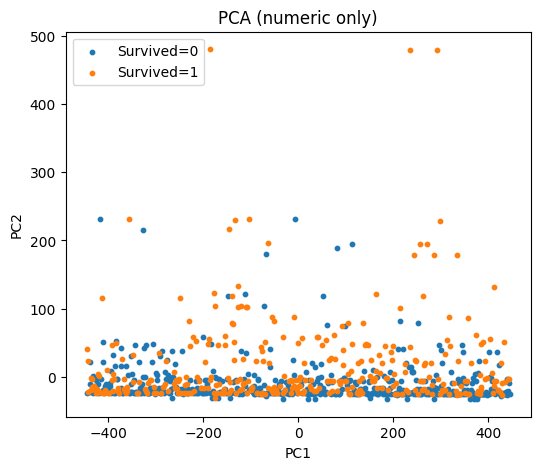

In [26]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [30]:
from sklearn.decomposition import PCA
import numpy as np

# Select relevant numeric columns (excluding PassengerId which is not a feature)
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
X = df_imp[numeric_cols].fillna(0) # Use df_imp after imputation

# Calculate and print variances before PCA
print("Column variances:\n", X.var().sort_values(ascending=False))

pca = PCA(n_components=2) # Change n_components to 2
pca.fit(X)

print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

Column variances:
 Fare     2469.436846
Age       169.512498
SibSp       1.216043
Parch       0.649728
dtype: float64
Cumulative explained variance: [0.93577071 0.99935507]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

ANS:
* The log1p transform of Fare.
* One-hot encoding produced more features.
* With the real Titanic dataset, you’d typically get ~77–80% accuracy.


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

# Reload the original dataframe
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)

df_proc = df.copy()

df_proc['Age'] = df_proc['Age'].fillna(df_proc['Age'].median())
df_proc['Embarked'] = df_proc['Embarked'].fillna(df_proc['Embarked'].mode()[0])
df_proc['Cabin'] = df_proc['Cabin'].fillna('Unknown')

scaler_std = StandardScaler()
df_proc['Age_std'] = scaler_std.fit_transform(df_proc[['Age']])

scaler_mm = MinMaxScaler()
df_proc['Fare_mm'] = scaler_mm.fit_transform(df_proc[['Fare']].fillna(0))

ohe = OneHotEncoder(sparse_output=False, drop=None)
encoded = ohe.fit_transform(df_proc[['Sex','Embarked']])
encoded_cols = ohe.get_feature_names_out(['Sex','Embarked'])
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df_proc.index)
df_proc = pd.concat([df_proc, df_encoded], axis=1)

df_proc['Fare_log'] = np.log1p(df_proc['Fare'].fillna(0))

num_subset = df_proc.select_dtypes(include=[np.number]).fillna(0)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(num_subset)
df_proc['PCA1'] = pca_result[:,0]
df_proc['PCA2'] = pca_result[:,1]

df_proc.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_std,Fare_mm,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare_log,PCA1,PCA2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,-0.565736,0.014151,0.0,1.0,0.0,0.0,1.0,2.110213,-445.074232,-24.012146
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.663861,0.139136,1.0,0.0,1.0,0.0,0.0,4.280593,-443.883625,40.480120
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,-0.258337,0.015469,1.0,0.0,0.0,0.0,1.0,2.188856,-443.065459,-23.230118
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.433312,0.103644,1.0,0.0,0.0,0.0,1.0,3.990834,-441.935027,22.212018
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,0.433312,0.015713,0.0,1.0,0.0,0.0,1.0,2.202765,-441.049252,-22.871215


## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).